In [125]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
import scipy.stats as st

In [126]:
path_to_data = '/Users/zeleninam2/Documents/projects/cbcl_ksads_work/revision_2023/data'
# wave in ['baseline_year_1_arm_1', '2_year_follow_up_y_arm_1']

In [135]:

# ----------------------
# DATA LOADING FUNCTONS
# ----------------------

# FUNCTION TO LOAD KSADS DATA, WHICH WE USE FOR _ALL_ ANALYSES

def load_ksads(path_to_mydata, reporter, wave, do_print = False):
    print('BEGIN LOADING KSADS...')
    assert reporter in ['parent','child'], "wrong reporter" # reporter has to be either parent or child
    assert wave in ['baseline', 'optimal'] # wrong wave
    # Load baseline data
    if reporter == 'child':
        path_to_ksads_data = path_to_mydata+'/abcd-data-release-5.1/core/mental-health/mh_y_ksads_ss.csv'
    elif reporter == 'parent':
        path_to_ksads_data = path_to_mydata+'/abcd-data-release-5.1/core/mental-health/mh_p_ksads_ss.csv'        
    ksads_data = pd.read_csv(path_to_ksads_data, sep=',', header=0, low_memory=False)
    # Select only baseline rows
    if wave == 'baseline':
        ksads_data_bsl = ksads_data.loc[ksads_data.eventname == 'baseline_year_1_arm_1'].copy()
    elif wave == 'optimal':
        ksads_data_bsl = ksads_data.loc[ksads_data.eventname == '2_year_follow_up_y_arm_1'].copy()        
    # check dimensions of the dataset
    if do_print:
        print('\nshape at loading, baseline only')
        print(ksads_data_bsl.shape)
    # ksads - only leave columns with name id and depression diagnoses
    if reporter == 'child':
        depression_column_list = [f'ksads_1_{x}_t' for x in [840, 841, 843, 844, 846]]
        adhd_column_list = ['ksads_14_856_t', 'ksads_14_855_t', 'ksads_14_853_t']
        anxiety_column_list = [ 'ksads_5_906_t',  'ksads_5_857_t', 'ksads_6_908_t',  'ksads_7_861_t',  'ksads_7_909_t',  'ksads_8_863_t',  'ksads_8_911_t', 'ksads_10_913_t', 'ksads_10_869_t', 'ksads_9_867_t']
    elif reporter == 'parent':
        depression_column_list = [f'ksads_1_{x}_p' for x in [840, 841, 843, 844, 846]]
        adhd_column_list = ['ksads_14_856_p', 'ksads_14_855_p', 'ksads_14_853_p']
        anxiety_column_list = [ 'ksads_5_906_p',  'ksads_5_857_p', 'ksads_6_908_p',  'ksads_7_861_p',  'ksads_7_909_p',  'ksads_8_863_p',  'ksads_8_911_p', 'ksads_10_913_p', 'ksads_10_869_p', 'ksads_9_867_p']
    col_list = ['src_subject_id']
    col_list += depression_column_list
    col_list += adhd_column_list
    col_list += anxiety_column_list
    anxiety_or_adhd_column_list = anxiety_column_list + adhd_column_list
    ksads_bsl_id_depanxadhd = ksads_data_bsl.loc[:, col_list]
    # ksads_dict_data = ksads_bsl_id_alldep.to_dict('records') # do we need this?
    # change types to float so I can work with them 
    ksads_bsl_id_depanxadhd = ksads_bsl_id_depanxadhd.set_index('src_subject_id')
    ksads_bsl_id_depanxadhd = ksads_bsl_id_depanxadhd.astype(float)
    # work with missing values (could be encoded as 555 or 888)
    if do_print:
        print('\nhow many nans:')
        for c in ksads_bsl_id_depanxadhd.columns:
            print(ksads_bsl_id_depanxadhd[c].value_counts())
    # in child data, there are some columns that are fully nan. remove them
    if reporter == 'child':
        nan_columns = ['ksads_14_856_t', 'ksads_14_855_t', 'ksads_14_853_t', 'ksads_9_867_t', 'ksads_5_906_t', 'ksads_5_857_t',  'ksads_6_908_t', 'ksads_7_861_t', 'ksads_7_909_t']
        # just do this once to check if everything in these columns are nans
        #print('\n check that nan-columns are truly nan')
        #for c in nan_columns:
            #print(ksads_bsl_id_depanxadhd[c].value_counts())
        ksads_bsl_id_depanxadhd = ksads_bsl_id_depanxadhd.drop(columns = nan_columns)
        # only keeping non-nan columns 
        adhd_column_list = []
        if reporter == 'child':
            anxiety_column_list = ['ksads_8_863_t', 'ksads_8_911_t', 'ksads_10_913_t', 'ksads_10_869_t']
        col_list = []
        col_list += depression_column_list
        col_list += adhd_column_list
        col_list += anxiety_column_list
        anxiety_or_adhd_column_list = anxiety_column_list + adhd_column_list
        ksads_bsl_id_depanxadhd = ksads_bsl_id_depanxadhd.loc[:, col_list]
    # dealing with nan rows
    # do this once to make sure values are 0, 1, or 555/888
    #for c in ksads_bsl_id_depanxadhd.columns:
        #print(ksads_bsl_id_depanxadhd[c].value_counts())
    # if encoded as 555 or 888, replace with nan
    ksads_bsl_id_depanxadhd[ksads_bsl_id_depanxadhd > 1.0] = np.nan
    # [QUESTION] ???
    #nnans = ksads_bsl_id_alldep.isnull().sum(1)
    #print('\nnnans')
    #print(nnans)
    #bad_ids = nnans[nnans > 1].index
    #print('\nbad ids')
    #print(bad_ids)
    #good_ids = nnans[nnans == 0].index
    #ksads_dat = (ksads_bsl_id_alldep.loc[good_ids].sum(1) > 0).astype(int)
    #print('\ngood id sum')
    #print(ksads_dat.sum())
    # drop all rows that include nans
    ksads_bsl_id_depanxadhd = ksads_bsl_id_depanxadhd.dropna()
    if do_print:
        print('\n shape after droping nans')
        print(ksads_bsl_id_depanxadhd.shape)
    # sum ksads scores of individual diagnoses to reach the overall ksads score, which we will use a gs
    ksads_bsl_id_depanxadhd['any_depression'] = (ksads_bsl_id_depanxadhd.loc[:, depression_column_list] > 0).sum(1) > 0
    ksads_bsl_id_depanxadhd['anxadhd_null'] = ksads_bsl_id_depanxadhd.loc[:, adhd_column_list + anxiety_column_list].isnull().sum(1) > 0
    ksads_bsl_id_depanxadhd['good'] = ksads_bsl_id_depanxadhd.any_depression | (~ksads_bsl_id_depanxadhd.anxadhd_null)
    bad_ids = ksads_bsl_id_depanxadhd.loc[~ksads_bsl_id_depanxadhd.good].index
    good_ids = ksads_bsl_id_depanxadhd.loc[ksads_bsl_id_depanxadhd.good].index
    if do_print:
        check1 = (ksads_bsl_id_depanxadhd.loc[:, depression_column_list].sum(1) > 0).astype(int)
        print('check1')
        print(check1.sum())
    ksads_dat = (ksads_bsl_id_depanxadhd.loc[good_ids, depression_column_list].sum(1) > 0).astype(int)
    ksads_dat = pd.DataFrame(ksads_dat).rename(columns={0:'ksads_DEPRESSION'})
    ksads_dat['ksads_ANXIETY'] = (ksads_bsl_id_depanxadhd.loc[good_ids, anxiety_column_list].sum(1) > 0).astype(int)
    ksads_dat['ksads_ADHD'] = (ksads_bsl_id_depanxadhd.loc[good_ids, adhd_column_list].sum(1) > 0).astype(int)
    ksads_dat['ksads_ADHD_OR_ANXIETY'] = (ksads_bsl_id_depanxadhd.loc[good_ids, anxiety_or_adhd_column_list].sum(1) > 0).astype(int)
    # sometimes the sum is more than one, if more than one depression diagnosis given
    # I want a binary value, so let's just put these to 1
    #ksads_bsl_id_dep[ksads_bsl_id_dep > 1.0] = 1.0
    if do_print:
        print('\nksads DEPRESSION value counts')
        print(ksads_dat['ksads_DEPRESSION'].value_counts())
    # creating different combinations of depression, anxiety, adhd comorbidities
    DEPyes_ANXADHDno = []
    DEPno_ANXADHDyes = []
    for index, row in ksads_dat.iterrows():
        if row['ksads_DEPRESSION'] == 1 and row['ksads_ADHD_OR_ANXIETY'] == 0:
            DEPyes_ANXADHDno.append(1)
        else:
            DEPyes_ANXADHDno.append(0)   
        if row['ksads_DEPRESSION'] == 0 and row['ksads_ADHD_OR_ANXIETY'] == 1:
            DEPno_ANXADHDyes.append(1)
        else:
            DEPno_ANXADHDyes.append(0)
    ksads_dat['ksads_DEPyes_ANXADHDno'] = DEPyes_ANXADHDno
    ksads_dat['ksads_DEPno_ANXADHDyes'] = DEPno_ANXADHDyes       
    # this is just renaming the sum depression columns
    #ksads_bsl_id_dep = pd.DataFrame(ksads_bsl_id_dep).rename(columns = {0:'ksads_dep_binary'})
    #if do_print:
        #print('\nfinal number of subjects overall')
        #print(ksads_bsl_id_dep.shape[0])
    if do_print:
        print('\nfinal sample size')
        print(ksads_dat.shape)
    print('\n...FINISH LOADING KSADS')
    return ksads_dat

# FUNCTION TO LOAD CBCL DATA

def load_cbcl(path_to_mydata, wave, do_print = False):
    print('BEGIN LOADING CBCL...')
    assert wave in ['baseline', 'optimal'] # wrong wave
    path_to_cbcl = path_to_data+'/abcd-data-release-5.1/core/mental-health/mh_p_cbcl.csv'
    cbcl_data = pd.read_csv(path_to_cbcl, sep=',', header=0, low_memory=False)
    if wave == 'baseline':
        cbcl_data_bsl = cbcl_data.loc[cbcl_data.eventname == 'baseline_year_1_arm_1'].copy()
    elif wave == 'optimal':
        cbcl_data_bsl = cbcl_data.loc[cbcl_data.eventname == '2_year_follow_up_y_arm_1'].copy() 
    if do_print:
        print('\ncbcl shape at loading, baseline only')
        print(cbcl_data_bsl.shape)
    # only leave columns with id and depression diagnosis
    # use RAW SCORE for depresison diagnosis, previously used cbcl_scr_dsm5_depress_t
    col_list_cbcl = ['src_subject_id', 'cbcl_scr_dsm5_depress_r']
    cbcl_bsl_id_dep = cbcl_data_bsl.loc[:, col_list_cbcl]
    cbcl_bsl_id_dep = cbcl_bsl_id_dep.set_index('src_subject_id')
    if do_print:
        print('\cbcl values')
        print(cbcl_bsl_id_dep.cbcl_scr_dsm5_depress_r.value_counts())
        print ('\nshape after merging')
        print(cbcl_bsl_id_dep.shape)
    cbcl_bsl_id_dep = cbcl_bsl_id_dep.dropna()
    if do_print:
        print ('\nshape after checking for nans')
        print(cbcl_bsl_id_dep.shape) 
    # rename input value
    #cbcl_bsl_id_dep = pd.DataFrame(cbcl_bsl_id_dep).rename(columns = {0:'input_measure'})
    cbcl_bsl_id_dep = cbcl_bsl_id_dep.rename(columns={"cbcl_scr_dsm5_depress_r": "input_measure"}, errors="raise")
    print('...FINISH LOADING CBCL')
    return cbcl_bsl_id_dep

def load_cbcl_anxdep_withdep(path_to_mydata, wave, do_print = False):
    # TODO
    print('BEGIN LOADING CBCL...')
    assert wave in ['baseline', 'optimal'] # wrong wave
    path_to_cbcl = path_to_data+'/abcd-data-release-5.1/core/mental-health/mh_p_cbcl.csv'
    cbcl_data = pd.read_csv(path_to_cbcl, sep=',', header=0, low_memory=False)
    if wave == 'baseline':
        cbcl_data_bsl = cbcl_data.loc[cbcl_data.eventname == 'baseline_year_1_arm_1'].copy()
    elif wave == 'optimal':
        cbcl_data_bsl = cbcl_data.loc[cbcl_data.eventname == '2_year_follow_up_y_arm_1'].copy() 
    if do_print:
        print('\ncbcl shape at loading, baseline only')
        print(cbcl_data_bsl.shape)
    # only leave columns with id and depression diagnosis
    # use RAW SCORE for depresison diagnosis, previously used cbcl_scr_dsm5_depress_t
    col_list_cbcl = ['src_subject_id', 'cbcl_scr_dsm5_depress_r']
    cbcl_bsl_id_dep = cbcl_data_bsl.loc[:, col_list_cbcl]
    cbcl_bsl_id_dep = cbcl_bsl_id_dep.set_index('src_subject_id')
    if do_print:
        print('\cbcl values')
        print(cbcl_bsl_id_dep.cbcl_scr_dsm5_depress_r.value_counts())
        print ('\nshape after merging')
        print(cbcl_bsl_id_dep.shape)
    cbcl_bsl_id_dep = cbcl_bsl_id_dep.dropna()
    if do_print:
        print ('\nshape after checking for nans')
        print(cbcl_bsl_id_dep.shape) 
    # rename input value
    #cbcl_bsl_id_dep = pd.DataFrame(cbcl_bsl_id_dep).rename(columns = {0:'input_measure'})
    cbcl_bsl_id_dep = cbcl_bsl_id_dep.rename(columns={"cbcl_scr_dsm5_depress_r": "input_measure"}, errors="raise")
    print('...FINISH LOADING CBCL')
    return cbcl_bsl_id_dep

def load_ysr(path_to_mydata, wave, do_print = False):
    '''
    From https://wiki.abcdstudy.org/release-notes/non-imaging/mental-health.html:
    Brief Problem Monitor (ASEBA) Release 5.0 Data Table: mh_y_bpm
    Measure Description: Normed multi-informant monitoring of children’s functioning. This is the youth self-report. 
    The BPM’s Internalizing (INT), Attention Problems (ATT), Externalizing (EXT), and Total Problems (TOT) scales 
    comprise items from the ASEBA Youth Self-Report (YSR). The items, scales, and norms are based on decades of research and 
    practical experience, as summarized in the BPM Manual (Achenbach, McConaughy, Ivanova, & Rescorla, 2017).
    '''
    print('BEGIN LOADING YSR...')
    path_to_ysr = path_to_data+'/abcd-data-release-5.1/core/mental-health/mh_y_bpm.csv'
    assert wave in ['optimal'] # wrong wave; there is no baseline data for ysr
    ysr_data = pd.read_csv(path_to_ysr, sep=',', header=0, low_memory=False)
    # optimal wave only; I could simplify it but maybe we'll change something in the future
    if wave == 'optimal':
        ysr_data_bsl = ysr_data.loc[ysr_data.eventname == '2_year_follow_up_y_arm_1'].copy() 
    if do_print:
        print('\nysr shape at loading, optimal wave only')
        print(ysr_data_bsl.shape)
    col_list = ['src_subject_id', 'bpm_y_scr_internal_r']
    ysr_data_intern = ysr_data_bsl.loc[:, col_list]
    ysr_data_intern = ysr_data_intern.set_index('src_subject_id')
    # remove nans
    ysr_data_intern = ysr_data_intern.dropna()
    if do_print:
        print ('\nshape after checking for nans')
        print(ysr_data_intern.shape)
    #ysr_data_intern = pd.DataFrame(ysr_data_intern).rename(columns = {0:'input_measure'})
    ysr_data_intern = ysr_data_intern.rename(columns={"bpm_y_scr_internal_r": "input_measure"}, errors="raise")
    print('...FINISH LOADING YSR')
    return ysr_data_intern

# FUNCTION TO MERGE DATASETS

def merge_my_data(measure_data, ksads_data, do_print = False):
    print('BEGIN MERGING...')
    # check if shapes of data match ot not
    if do_print:
        print('samples in measure (cbcl,ysr,...) data:')
        print(measure_data.shape)
        print('samples in gold standard (ksads) data:')
        print(ksads_data.shape)  
    # merge on ksads data
    # merging on ksads because we need all subjects to have a gold standard ksads number
    data_ksads_and_measure = pd.merge(ksads_data, measure_data, how='left', left_index = True, right_index = True, indicator=True)
    # check if there are items that are present in only one dataframe
    if len(data_ksads_and_measure.query('_merge != "both"')) != 0:
        print('merge indicator:')
        print(data_ksads_and_measure._merge.value_counts())
        print(data_ksads_and_measure.loc[data_ksads_and_measure._merge == 'left_only'])
    # only keep rows that have data from *both* dataframes
    data_ksads_and_measure = data_ksads_and_measure.loc[data_ksads_and_measure._merge == 'both'].drop(columns=['_merge']) 
    # shape after merging
    if do_print:
        print('\shape after merging')
        print(data_ksads_and_measure.shape)
    # I don't think we need to do this. This was removing null values, whoch is how missing data used to be encoded.
    # cbcl_t takes values form 50 to 50-something.
    # cbcl_r takes values from 0 to 19, and so 0 is meaningful.
    #data_ksads_cbcl = data_ksads_cbcl.loc[data_ksads_cbcl.cbcl_scr_dsm5_depress_t.notnull()].copy()
    #data_ksads_cbcl['cbcl_scr_dsm5_depress_t'] = data_ksads_cbcl.cbcl_scr_dsm5_depress_t.astype(int)
    # We shouldn't have any nans but let's heck just to be extra careful
    data_ksads_and_measure = data_ksads_and_measure.dropna()
    if do_print:
        print ('\nshape after checking for nans')
        print(data_ksads_and_measure.shape) 
    print('...FINISH MERGING')
    return data_ksads_and_measure

def preprocess_data(my_data, percent_positives, hypothesis, sex='both', do_print=False):
    # split into negative and positive diagnoses based on desired percentage
    print ('BEGIN PREPROCESSING...')
    null_rows = my_data.input_measure.isnull().sum()
    print('\nLast check of missing data. Non-null rows = %d' % (null_rows))
    # split into negative and positive ksads diagnoses
    if hypothesis == '1':
        is_pos =  my_data['ksads_DEPRESSION']==1 
        is_neg =  (my_data['ksads_DEPRESSION']==0) & (my_data['input_measure'].notnull() )
    elif hypothesis == '2a':
        # this seems correct...
        is_pos = my_data['ksads_DEPRESSION']==1
        #is_neg = (my_data['ksads_DEPRESSION']==0) & (my_data['ksads_ADHD_OR_ANXIETY']==1) & (my_data['input_measure'].notnull() )
        is_neg = (my_data['ksads_DEPno_ANXADHDyes']==1) & (my_data['input_measure'].notnull())
    elif hypothesis == '2b':
        # this also seems correct...
        is_pos = my_data['ksads_DEPyes_ANXADHDno']==1
        is_neg = (my_data['ksads_DEPno_ANXADHDyes']==1) & (my_data['input_measure'].notnull())
    else:
        print('WRONG HYPOTHESIS')
    pos_ksads_all = my_data[is_pos]
    neg_ksads_all = my_data[is_neg]
    # lets check that they don't overlap
    print('\nCheck that positives and negatives dont overlap')
    idx = pos_ksads_all.index.intersection(neg_ksads_all.index)
    print(idx)
    # randomly choose the negative subsample
    num_pos = pos_ksads_all.shape[0] # this is how many positives we have. using all of them
    num_neg_all = neg_ksads_all.shape[0] # this is how many negatives we have 
    pos_rate = (100-percent_positives)/10
    num_neg_want = num_pos*pos_rate # this is how many negatives we want
    print('FINAL Number of positives in the data n=%d' % (num_pos))
    print('Number of negatives in the data (before subsampling) n=%d' % (num_neg_all))  
    print('Overall sample size (before subsampling) n=%d' % (num_pos + num_neg_all))
    if num_neg_want >= num_neg_all: # if we want more negatives than we have, or all of the negatives that we have
        print('Not enough negative samples to use the desired neg/pos rate. Using all negative samples')
        neg_ksads_subsample = neg_ksads_all # then use all of them
    else: # otherwise:
        size_subsample = num_pos*percent_positives-num_pos
        neg_ksads_subsample = neg_ksads_all.sample(n = size_subsample) # choose a subsample of negatives of our desired proportion
    print('FINAL Number of negatives in the data (after subsampling) n=%d' % (neg_ksads_subsample.shape[0])) 
    print('FINAL Overall sample size (before subsampling) n=%d' % (num_pos + neg_ksads_subsample.shape[0]))
    # mix all positives and negatives. Then shuffle (I don't why but won't hurt)
    frames = [pos_ksads_all, neg_ksads_subsample]
    my_subsample = pd.concat(frames)
    my_subsample = my_subsample.sample(frac = 1)
    # THIS IS NEW SEX/GENDER STUFF
    if sex == 'both':
        print ('\n...END PREPROCESSING')
        return my_subsample
    else:
        path_to_demo_data = path_to_data+'/abcd-data-release-5.1/core/abcd-general/abcd_p_demo.csv'
        demo_data = pd.read_csv(path_to_demo_data, sep=',', header=0, low_memory=False)
            # demo_sex_v2 - sex at birth
            # 1 = Male Masculino; 
            # 2 = Female Femenino; 
            # 3 = Intersex-Male Entre sexo-masculino; 
            # 4 = Intersex-Female Entre sexo-femenino; 
            # 999 = Don't know No lo s√É¬©; 
            # 777 = Refuse to answer Prefiero no responder
            # demo_gender_id_v2 - current gender identity
            # 1 = Male Hombre; 
            # 2 = Female Mujer; 
            # 3 = Trans male Transexual masculino / hombre transexual; 
            # 4 = Trans female Transexual femenino / mujer transexual; 
            # 5 = Gender queer Interg√É¬©nero ("genderqueer") / No conforme con el g√É¬©nero; 
            # 6 = Different Otra identididad; 
            # 777 = Refuse to answer Niego contestar; 
            # 999 = Don't know No lo s√É¬©
        # merge my dataframe with demo dataframe
        # merge on subsamples data
        #print(demo_data.src_subject_id.value_counts())
        values = demo_data['src_subject_id'].value_counts().keys().tolist()
        counts = demo_data['src_subject_id'].value_counts().tolist()
        if do_print:
            print(counts)
        demo_data = demo_data.set_index('src_subject_id')
        # demo_data = demo_data.loc[:, ['demo_sex_v2', 'demo_gender_id_v2']]
        demo_data = demo_data.loc[:, ['demo_sex_v2']]
        demo_data = demo_data.dropna()
        data_with_sex = pd.merge(my_subsample, demo_data, how='left', left_index = True, right_index = True, indicator=True)
        # check if there are items that are present in only one dataframe
        if do_print:
            if len(data_with_sex.query('_merge != "both"')) != 0:
                print('SOMETHING WRONG WITH MERGE')
                print('merge indicator:')
                print(data_with_sex._merge.value_counts())
                print(data_with_sex.loc[data_with_sex._merge == 'left_only'])
        # only keep rows that have data from *both* dataframes
        data_with_sex = data_with_sex.loc[data_with_sex._merge == 'both'].drop(columns=['_merge']) 
        print(data_with_sex['demo_sex_v2'].value_counts())
        data_boys = data_with_sex.query('demo_sex_v2 == 1.0')
        data_girls = data_with_sex.query('demo_sex_v2 == 2.0')
        # output positive and negative samples from boys and girls
        if hypothesis == '1' or hypothesis == '2a':
            girls_pos = data_girls.query('ksads_DEPRESSION == 1')
            boys_pos = data_boys.query('ksads_DEPRESSION == 1')
        elif hypothesis == '2b':
            girls_pos = data_girls.query('ksads_DEPyes_ANXADHDno == 1')
            boys_pos = data_boys.query('ksads_DEPyes_ANXADHDno == 1')
        print('Positive girls in sample = %d' % girls_pos.shape[0])
        print('Positive boys in sample = %d' % boys_pos.shape[0])
        print ('\n...END PREPROCESSING')
        if sex == 'boys':
            return data_boys
        elif sex == 'girls':
            return data_boys
        else:
            print('WRONG GENDER')
    
# -----------------
# ANALYSIS FUNCTONS
# -----------------

# help function for bootstrapping
def gen_auc_boots(scores, truth, nboots, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    boot_res = []
    for pp in range(nboots):
        boot_ind = rng.choice(range(len(truth)), size=truth.size, replace=True)
        boot_truth = truth.iloc[boot_ind]
        boot_score = scores.iloc[boot_ind]
        boot_res.append(roc_auc_score(boot_truth, boot_score))
    return np.array(boot_res)

# main analysis function
def run_aucroc_and_plot(my_dat, path_to_save_plots, name_to_save, mymeasure, hypothesis, nboots=100, target_auc=0.8, do_print = False):
    # [TODO] CHANGE TARGET_AUC FOR HYP 2B
    # using https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    print('BEGIN AUCROC...')
    if do_print:
        print(my_dat.head())
    y_measure_df = my_dat['input_measure'] # called y_score in the example
    # I'm getting weird scores for H2a, 2b
    # I think the problem is here
    if hypothesis in ['1', '2a']:   
        y_true_df = my_dat['ksads_DEPRESSION'] # called y_test in the example
    elif hypothesis == '2b':
        y_true_df = my_dat['ksads_DEPyes_ANXADHDno'] # called y_test in the example
    if do_print:
        print(my_dat.head())        
    sample_auc_score = roc_auc_score(y_true_df, y_measure_df)
    print('\nSingle AUCROC score without bootstrapping:')
    print(sample_auc_score)
    #print('\nSingle AUCROC score without bootstrapping = %d' % (sample_auc_score))
    # plotting
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_true_df, y_measure_df)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    # We save the data for future plotting of all hypotheses in one figure, for the paper
    with open(path_to_save_plots+name_to_save+'_true.npy', 'wb') as f:
        np.save(f, y_true_df)
    with open(path_to_save_plots+name_to_save+'_'+mymeasure+'.npy', 'wb') as f:
        np.save(f, y_measure_df)
    # bootstrapping
    boot_ind = np.random.choice(range(len(y_true_df)), size=y_true_df.size, replace=True)
    boot_truth = y_true_df.iloc[boot_ind]
    boot_score = y_measure_df.iloc[boot_ind]
    rng = np.random.default_rng()
    boots = gen_auc_boots(y_measure_df, y_true_df, nboots=1000, rng=rng)
    boots = np.hstack([boots, np.array([sample_auc_score])])
    #print('min bootstrapping aucroc = %d' % (min(boots)))
    #print('max bootstrapping aucroc = %d' % (max(boots)))  
    print('min bootstrapping aucroc:')
    print(min(boots))
    print('max bootstrapping aucroc:')
    print(max(boots))
    p_onesided = (boots >= target_auc).mean()
    print('p_onesided = %d' % (p_onesided))  
    p_twosided1 = (boots > target_auc).mean()
    p_twosided2 = (boots < target_auc).mean()
    p_twosided = min(p_twosided1, p_twosided2)*2
    print('p_twosided = %d' % (p_twosided))  
    boots_mean_AUCROC = np.mean(boots)
    q_25 = np.quantile(boots, .025)
    q_75 = np.quantile(boots, .975)
    #print('boots_mean_AUCROC = %d(%d, %d)' % (boots_mean_AUCROC, q_25, q_75)) # why is this not working?
    print('boots_mean_AUCROC =')
    print(str(boots_mean_AUCROC)+'('+str(q_25)+','+str(q_75)+')') # this is so ugly omg but at least it's working
    # for confusion matrix for optimal thresholds:
    y_true = y_true_df.tolist()
    y_measure = y_measure_df.tolist()
    print('\n...END AUCROC')
    return (y_true, y_measure)

# confusion matrices for optimal score

# help function 
def predict_y(cbcl, threshold):
    y_score = []
    for item in cbcl:
        if item >= threshold:
            y_score.append(1)
        else:
            y_score.append(0)
    return y_score

# function that calculates confusion matrices and outputs the optimal threshold
def do_optimal_threshold(myscore, truescore):
    # Create a dataframe for all data for thresholds and associated fpr, tpr, tp, tn, fp, fn
    # and also euclidian distance
    # --> tpr - y axis 
    # --> fpr - x axis 
    # We want to calculate an Euclidian distance to (0,1) for each point on the ROC curve and pick the point where that is minimized. 
    ## dist = sqrt((x2 - x1)^2 + (y2 - y1)^2) 
    ## dist = sqrt(square(x2 - x1) + square(y2 - y1)) 
    # I will create the df from a list of lists
    # first initiate the lists
    all_roc_auc = []
    all_fpr = []
    all_tpr = []
    all_tn = []
    all_fp = []
    all_fn = []
    all_tp = []
    all_thresholds = []
    all_euclidian = []
    # Point to calculate the Euclidian distance with - (0, 1)
    optimal_performance = np.array((0, 1))
    # now iterate through thesholds, calculate the values of interest, update the lists
    for threshold in list(range(int(min(myscore)), int(max(myscore))+1)): # this is so ugly omg
        # predict diagnoses with the given threshold
        y_score = predict_y(y_measure, threshold)
        # calculate fp, fn, tp, tn, aucroc
        tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()
        fpr = fp/(fp+tn)
        tpr = tp/(tp+fn)
        # calculate euclidian
        fpr_tpr_datapoint = np.array((fpr, tpr))
        sum_sq = np.sum(np.square(optimal_performance - fpr_tpr_datapoint))
        euclidian = np.sqrt(sum_sq)
        # update all lists
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_tn.append(tn)
        all_fp.append(fp)
        all_fn.append(fn)
        all_tp.append(tp)
        all_thresholds.append(threshold)
        all_euclidian.append(euclidian)
    # make a dataframe out of lists
    conf_matrices_data = pd.DataFrame(list(zip(all_thresholds, all_euclidian, all_fpr, all_tpr, all_tp, all_tn, all_fp, all_fn)), columns =['threshold', 'Euclidian', 'FPR', 'TPR', 'TP', 'TN', 'FP', 'FN'])
    print(conf_matrices_data)
    print('\nMaximized:')
    print(conf_matrices_data).loc[2]
    # What is the min euclidian distance in the dataframe?
    print('Euclidian:')
    print(conf_matrices_data[['Euclidian']].idxmin())


In [136]:
# data we have
# dat_cbcl_ksads_p_bsl
# dat_cbcl_ksads_c_bsl
# dat_cbcl_ksads_p_opt
# dat_cbcl_ksads_c_opt
# dat_ysr_ksads_p
# dat_ysr_ksads_c


Input Data: cbcl
Wave: baseline
Ksads Reporter: parent
Hypothesis: 1
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
merge indicator:
_merge
both          6184
left_only        2
right_only       0
Name: count, dtype: int64
                  ksads_DEPRESSION  ksads_ANXIETY  ksads_ADHD  \
src_subject_id                                                  
NDAR_INVFZWKRBW7                 0              0           0   
NDAR_INVJHJDGEFN                 0              0           0   

                  ksads_ADHD_OR_ANXIETY  ksads_DEPyes_ANXADHDno  \
src_subject_id                                                    
NDAR_INVFZWKRBW7                      0                       0   
NDAR_INVJHJDGEFN                      0                       0   

                  ksads_DEPno_ANXADHDyes  input_measure     _merge  
src_subject_id                                                      
NDAR_INVFZWKRBW7                 

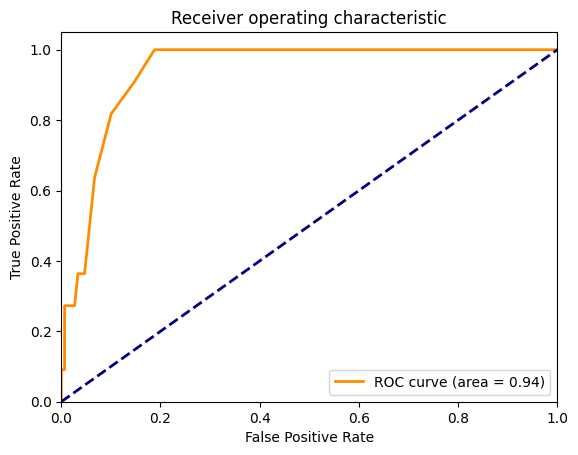

min bootstrapping aucroc:
0.8227848101265822
max bootstrapping aucroc:
0.9873333333333334
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9383573726324128(0.8940345368916798,0.975328947368421)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 1
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
merge indicator:
_merge
both          10701
left_only        23
right_only        0
Name: count, dtype: int64
                  ksads_DEPRESSION  ksads_ANXIETY  ksads_ADHD  \
src_subject_id                                                  
NDAR_INV0AU5R8NA                 0              0           0   
NDAR_INV1DDX454E                 0              0           0   
NDAR_INV2L17MHHT                 0              0           0   
NDAR_INV3E7ZYR64                 0              1           0   
NDAR_INV4BA28Y80                 0              0           0   
NDAR_INV4XK3J70P       

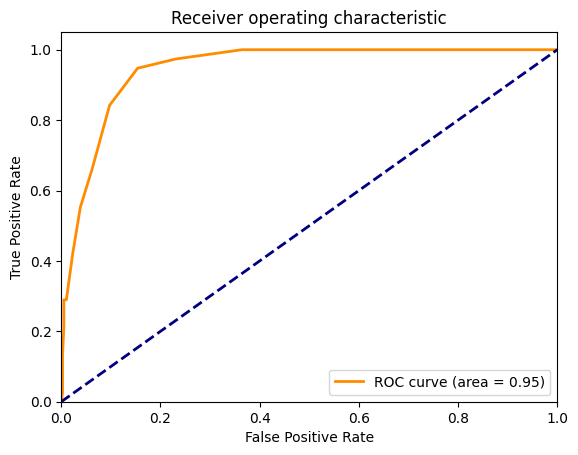

min bootstrapping aucroc:
0.8815765629719119
max bootstrapping aucroc:
0.9752946366672969
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.946833034464799(0.9221428571428572,0.9682142857142857)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: parent
Hypothesis: 2a
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
merge indicator:
_merge
both          6184
left_only        2
right_only       0
Name: count, dtype: int64
                  ksads_DEPRESSION  ksads_ANXIETY  ksads_ADHD  \
src_subject_id                                                  
NDAR_INVFZWKRBW7                 0              0           0   
NDAR_INVJHJDGEFN                 0              0           0   

                  ksads_ADHD_OR_ANXIETY  ksads_DEPyes_ANXADHDno  \
src_subject_id                                                    
NDAR_INVFZWKRBW7                      0                       0   
NDAR_INVJHJDGEFN 

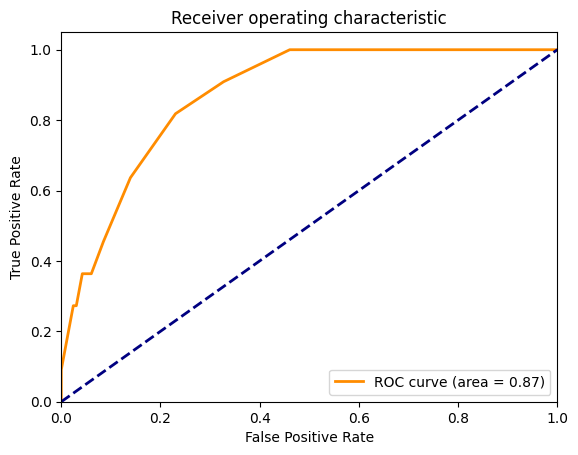

min bootstrapping aucroc:
0.7309941520467836
max bootstrapping aucroc:
0.9927325581395349
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8707537841279062(0.784297520661157,0.9453760162601625)

...END AUCROC

FINISH


Input Data: cbcl
Wave: optimal
Ksads Reporter: parent
Hypothesis: 2a
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
merge indicator:
_merge
both          10701
left_only        23
right_only        0
Name: count, dtype: int64
                  ksads_DEPRESSION  ksads_ANXIETY  ksads_ADHD  \
src_subject_id                                                  
NDAR_INV0AU5R8NA                 0              0           0   
NDAR_INV1DDX454E                 0              0           0   
NDAR_INV2L17MHHT                 0              0           0   
NDAR_INV3E7ZYR64                 0              1           0   
NDAR_INV4BA28Y80                 0              0           0   
NDAR_INV4XK3J70P      

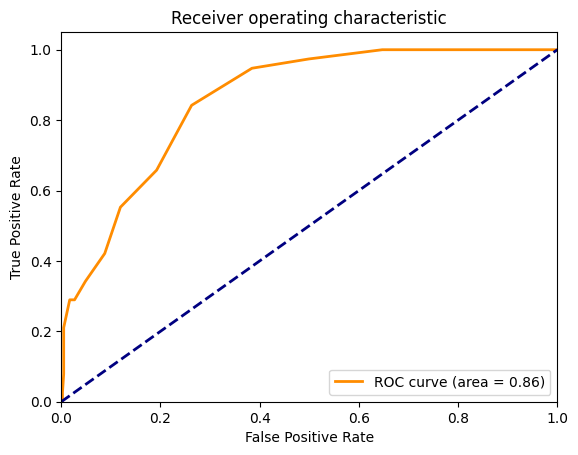

min bootstrapping aucroc:
0.7751789976133652
max bootstrapping aucroc:
0.9306682577565633
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8567975923640596(0.8055448841080805,0.9029706066291431)

...END AUCROC

FINISH


Input Data: cbcl
Wave: baseline
Ksads Reporter: parent
Hypothesis: 2b
Sex: boys


BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
merge indicator:
_merge
both          6184
left_only        2
right_only       0
Name: count, dtype: int64
                  ksads_DEPRESSION  ksads_ANXIETY  ksads_ADHD  \
src_subject_id                                                  
NDAR_INVFZWKRBW7                 0              0           0   
NDAR_INVJHJDGEFN                 0              0           0   

                  ksads_ADHD_OR_ANXIETY  ksads_DEPyes_ANXADHDno  \
src_subject_id                                                    
NDAR_INVFZWKRBW7                      0                       0   
NDAR_INVJHJDGEFN

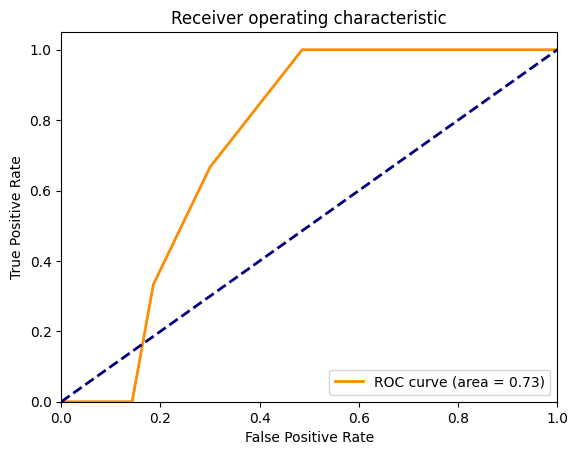

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [137]:
#for Sex in ['both', 'boys', 'girls']:
for Sex in ['boys', 'girls']:
    for Input_data in ['cbcl', 'ysr']:
        for Reporter in ['parent','child']:
            for Hypothesis in ['1','2a','2b']:
                if Input_data == 'cbcl':
                    for Wave in ['baseline', 'optimal']:
                        print('\nInput Data: %s' % Input_data)
                        print('Wave: %s' % Wave)
                        print('Ksads Reporter: %s' % Reporter)
                        print('Hypothesis: %s' % Hypothesis)
                        print('Sex: %s' % Sex)
                        print('\n')
                        data_ksads = load_ksads(path_to_data, reporter = Reporter, wave = Wave, do_print = False)
                        data_input = load_cbcl(path_to_data, wave = Wave)
                        data_merged = merge_my_data(data_input, data_ksads)     
                        data_ready = preprocess_data(data_merged, percent_positives = 10, hypothesis = Hypothesis, sex = Sex)
                        print('\nFINISHED DATA PREP\n')
                        # STARTING ANALYSIS
                        print('\nSTART ANALYSIS\n')
                        print('\nInput Data: %s' % Input_data)
                        print('Wave: %s' % Wave)
                        print('Ksads Reporter: %s' % Reporter)
                        print('Hypothesis: %s' % Hypothesis) 
                        print('Sex: %s' % Sex)
                        if Hypothesis in ['1', '2a']:
                            Target_auc = 0.8 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                        elif Hypothesis == '2b':
                            Target_auc = 0.7 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                        fig_file_name = 'ABCD_'+Input_data+'_'+Hypothesis+'_'+Reporter+'_'+Wave
                        y_true,y_measure = run_aucroc_and_plot(data_ready, 
                                                                path_to_save_plots='../', 
                                                                name_to_save=fig_file_name, 
                                                                mymeasure = Input_data, 
                                                                hypothesis = Hypothesis,
                                                                nboots=100, 
                                                                target_auc=Target_auc)
                        print('\nFINISH\n')
    
                elif Input_data == 'ysr':
                    Wave = 'optimal'
                    print('\nInput Data: %s' % Input_data)
                    print('Wave: Always optimal')
                    print('Ksads Reporter: %s' % Reporter)
                    print('Hypothesis: %s' % Hypothesis)
                    print('Sex: %s' % Sex)
                    print('\n')
                    data_ksads = load_ksads(path_to_data, reporter = Reporter, wave = Wave, do_print = False)
                    data_input = load_ysr(path_to_data, wave = Wave)
                    data_merged = merge_my_data(data_input, data_ksads)     
                    data_ready = preprocess_data(data_merged, percent_positives = 10, hypothesis = Hypothesis, sex = Sex)
                    print('\nFINISHED DATA PREP\n')
                    # STARTING ANALYSIS
                    print('\nSTART ANALYSIS\n')
                    print('\nInput Data: %s' % Input_data)
                    print('Wave: %s' % Wave)
                    print('Ksads Reporter: %s' % Reporter)
                    print('Hypothesis: %s' % Hypothesis)
                    print('Sex: %s' % Sex)
                    if Hypothesis in ['1', '2a']:
                        Target_auc = 0.8 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                    elif Hypothesis == '2b':
                        Target_auc = 0.7 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                    fig_file_name = 'ABCD_'+Input_data+'_'+Hypothesis+'_'+Reporter+'_'+Wave
                    y_true,y_measure = run_aucroc_and_plot(data_ready, 
                                                                path_to_save_plots='../', 
                                                                name_to_save=fig_file_name, 
                                                                mymeasure = Input_data, 
                                                                hypothesis = Hypothesis,
                                                                nboots=100, 
                                                                target_auc=Target_auc)
                    print('\nFINISH\n')
                else: 
                    print('\nWRONG INPUT DATA')

print('\nFINISH ALL\n')

In [89]:
# experiments with gender
path_to_demo_data = path_to_data+'/abcd-data-release-5.1/core/abcd-general/abcd_p_demo.csv'

In [90]:
demo_data = pd.read_csv(path_to_demo_data, sep=',', header=0, low_memory=False)
demo_data.head()

,src_subject_id,eventname,demoi_p_select_language___1,demo_prim,demo_brthdat_v2,demo_ed_v2,demo_adopt_agex_v2,demo_adopt_agex_v2_bl_dk,demo_sex_v2,demo_gender_id_v2,...,demo_nat_lang_3_yrs_other_p_14,demo_nat_lang_3_p,demo_nat_lang_3_yrs_eng_p___1,demo_nat_lang_3_yrs_eng_p___2,demo_nat_lang_3_yrs_eng_p___3,demo_nat_lang_3_yrs_eng_p___4,demo_nat_lang_3_yrs_eng_p___5,demo_nat_lang_3_yrs_eng_p___6,race_ethnicity,acs_raked_propensity_score
0,NDAR_INV003RTV85,baseline_year_1_arm_1,0,1.0,10.0,5.0,NaN,NaN,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,466.092707
1,NDAR_INV003RTV85,1_year_follow_up_y_arm_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,533.381820
2,NDAR_INV003RTV85,2_year_follow_up_y_arm_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NDAR_INV003RTV85,3_year_follow_up_y_arm_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NDAR_INV005V6D2C,baseline_year_1_arm_1,1,1.0,10.0,4.0,NaN,NaN,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,520.488325


In [91]:
list(demo_data.columns)
# demo_sex_v2 - sex at birth
# 1 = Male Masculino; 
# 2 = Female Femenino; 
# 3 = Intersex-Male Entre sexo-masculino; 
# 4 = Intersex-Female Entre sexo-femenino; 
# 999 = Don't know No lo s√É¬©; 
# 777 = Refuse to answer Prefiero no responder
# demo_gender_id_v2 - current gender identity
# 1 = Male Hombre; 
# 2 = Female Mujer; 
# 3 = Trans male Transexual masculino / hombre transexual; 
# 4 = Trans female Transexual femenino / mujer transexual; 
# 5 = Gender queer Interg√É¬©nero ("genderqueer") / No conforme con el g√É¬©nero; 
# 6 = Different Otra identididad; 
# 777 = Refuse to answer Niego contestar; 
# 999 = Don't know No lo s√É¬©

['src_subject_id',
 'eventname',
 'demoi_p_select_language___1',
 'demo_prim',
 'demo_brthdat_v2',
 'demo_ed_v2',
 'demo_adopt_agex_v2',
 'demo_adopt_agex_v2_bl_dk',
 'demo_sex_v2',
 'demo_gender_id_v2',
 'demo_race_a_p___10',
 'demo_race_a_p___11',
 'demo_race_a_p___12',
 'demo_race_a_p___13',
 'demo_race_a_p___14',
 'demo_race_a_p___15',
 'demo_race_a_p___16',
 'demo_race_a_p___17',
 'demo_race_a_p___18',
 'demo_race_a_p___19',
 'demo_race_a_p___20',
 'demo_race_a_p___21',
 'demo_race_a_p___22',
 'demo_race_a_p___23',
 'demo_race_a_p___24',
 'demo_race_a_p___25',
 'demo_race_a_p___77',
 'demo_race_a_p___99',
 'demo_ethn_v2',
 'demo_ethn2_v2',
 'demo_origin_v2',
 'demo_years_us_v2',
 'demo_years_us_v2_dk',
 'demo_relig_v2',
 'demo_prnt_age_v2',
 'demo_prnt_age_v2_bl_refuse',
 'demo_prnt_gender_id_v2',
 'demo_prnt_race_a_v2___10',
 'demo_prnt_race_a_v2___11',
 'demo_prnt_race_a_v2___12',
 'demo_prnt_race_a_v2___13',
 'demo_prnt_race_a_v2___14',
 'demo_prnt_race_a_v2___15',
 'demo_prnt_

In [100]:
Input_data = 'cbcl'
Reporter = 'parent'
hypothesis = '1'
Wave = 'baseline'
data_ksads = load_ksads(path_to_data, reporter = Reporter, wave = Wave, do_print = False)
data_input = load_cbcl(path_to_data, wave = Wave)
my_data = merge_my_data(data_input, data_ksads)  
percent_positives = 10

BEGIN LOADING KSADS...

...FINISH LOADING KSADS
BEGIN LOADING CBCL...
...FINISH LOADING CBCL
BEGIN MERGING...
merge indicator:
_merge
both          6184
left_only        2
right_only       0
Name: count, dtype: int64
                  ksads_DEPRESSION  ksads_ANXIETY  ksads_ADHD  \
src_subject_id                                                  
NDAR_INVFZWKRBW7                 0              0           0   
NDAR_INVJHJDGEFN                 0              0           0   

                  ksads_ADHD_OR_ANXIETY  ksads_DEPyes_ANXADHDno  \
src_subject_id                                                    
NDAR_INVFZWKRBW7                      0                       0   
NDAR_INVJHJDGEFN                      0                       0   

                  ksads_DEPno_ANXADHDyes  input_measure     _merge  
src_subject_id                                                      
NDAR_INVFZWKRBW7                       0            NaN  left_only  
NDAR_INVJHJDGEFN                       0      

In [122]:
sex = 'boys'

# THIS STUFF IS FROM PREPROCESS_DATA FUNCITON WITH NO EDITS 

# split into negative and positive diagnoses based on desired percentage
print ('BEGIN PREPROCESSING...')
null_rows = my_data.input_measure.isnull().sum()
print('\nLast check of missing data. Non-null rows = %d' % (null_rows))
# split into negative and positive ksads diagnoses
if hypothesis == '1':
    is_pos =  my_data['ksads_DEPRESSION']==1 
    is_neg =  (my_data['ksads_DEPRESSION']==0) & (my_data['input_measure'].notnull() )
elif hypothesis == '2a':
    # this seems correct...
    is_pos = my_data['ksads_DEPRESSION']==1
    #is_neg = (my_data['ksads_DEPRESSION']==0) & (my_data['ksads_ADHD_OR_ANXIETY']==1) & (my_data['input_measure'].notnull() )
    is_neg = (my_data['ksads_DEPno_ANXADHDyes']==1) & (my_data['input_measure'].notnull())
elif hypothesis == '2b':
    # this also seems correct...
    is_pos = my_data['ksads_DEPyes_ANXADHDno']==1
    is_neg = (my_data['ksads_DEPno_ANXADHDyes']==1) & (my_data['input_measure'].notnull())
else:
    print('WRONG HYPOTHESIS')
pos_ksads_all = my_data[is_pos]
neg_ksads_all = my_data[is_neg]
# lets check that they don't overlap
print('\nCheck that positives and negatives dont overlap')
idx = pos_ksads_all.index.intersection(neg_ksads_all.index)
print(idx)
# randomly choose the negative subsample
num_pos = pos_ksads_all.shape[0] # this is how many positives we have. using all of them
num_neg_all = neg_ksads_all.shape[0] # this is how many negatives we have 
pos_rate = (100-percent_positives)/10
num_neg_want = num_pos*pos_rate # this is how many negatives we want
print('FINAL Number of positives in the data n=%d' % (num_pos))
print('Number of negatives in the data (before subsampling) n=%d' % (num_neg_all))  
print('Overall sample size (before subsampling) n=%d' % (num_pos + num_neg_all))
if num_neg_want >= num_neg_all: # if we want more negatives than we have, or all of the negatives that we have
    print('Not enough negative samples to use the desired neg/pos rate. Using all negative samples')
    neg_ksads_subsample = neg_ksads_all # then use all of them
else: # otherwise:
    size_subsample = num_pos*percent_positives-num_pos
    neg_ksads_subsample = neg_ksads_all.sample(n = size_subsample) # choose a subsample of negatives of our desired proportion
print('FINAL Number of negatives in the data (after subsampling) n=%d' % (neg_ksads_subsample.shape[0])) 
print('FINAL Overall sample size (before subsampling) n=%d' % (num_pos + neg_ksads_subsample.shape[0]))
# mix all positives and negatives. Then shuffle (I don't why but won't hurt)
frames = [pos_ksads_all, neg_ksads_subsample]
my_subsample = pd.concat(frames)
my_subsample = my_subsample.sample(frac = 1)

#my_s = my_subsample.reset_index()
#print(my_s.src_subject_id.value_counts())


# THIS IS NEW SEX/GENDER STUFF
if sex != 'both':
    path_to_demo_data = path_to_data+'/abcd-data-release-5.1/core/abcd-general/abcd_p_demo.csv'
    demo_data = pd.read_csv(path_to_demo_data, sep=',', header=0, low_memory=False)
        # demo_sex_v2 - sex at birth
        # 1 = Male Masculino; 
        # 2 = Female Femenino; 
        # 3 = Intersex-Male Entre sexo-masculino; 
        # 4 = Intersex-Female Entre sexo-femenino; 
        # 999 = Don't know No lo s√É¬©; 
        # 777 = Refuse to answer Prefiero no responder
        # demo_gender_id_v2 - current gender identity
        # 1 = Male Hombre; 
        # 2 = Female Mujer; 
        # 3 = Trans male Transexual masculino / hombre transexual; 
        # 4 = Trans female Transexual femenino / mujer transexual; 
        # 5 = Gender queer Interg√É¬©nero ("genderqueer") / No conforme con el g√É¬©nero; 
        # 6 = Different Otra identididad; 
        # 777 = Refuse to answer Niego contestar; 
        # 999 = Don't know No lo s√É¬©
    # merge my dataframe with demo dataframe
    # merge on subsamples data
    #print(demo_data.src_subject_id.value_counts())
    values = demo_data['src_subject_id'].value_counts().keys().tolist()
    counts = demo_data['src_subject_id'].value_counts().tolist()
    #print(counts)
    demo_data = demo_data.set_index('src_subject_id')
    # demo_data = demo_data.loc[:, ['demo_sex_v2', 'demo_gender_id_v2']]
    demo_data = demo_data.loc[:, ['demo_sex_v2']]
    demo_data = demo_data.dropna()
    data_with_sex = pd.merge(my_subsample, demo_data, how='left', left_index = True, right_index = True, indicator=True)
    # check if there are items that are present in only one dataframe
    if len(data_with_sex.query('_merge != "both"')) != 0:
        print('SOMETHING WRONG WITH MERGE')
        print('merge indicator:')
        print(data_with_sex._merge.value_counts())
        print(data_with_sex.loc[data_with_sex._merge == 'left_only'])
    # only keep rows that have data from *both* dataframes
    data_with_sex = data_with_sex.loc[data_with_sex._merge == 'both'].drop(columns=['_merge']) 
    print(data_with_sex['demo_sex_v2'].value_counts())
    data_boys = data_with_sex.query('demo_sex_v2 == 1.0')
    data_girls = data_with_sex.query('demo_sex_v2 == 2.0')
    




BEGIN PREPROCESSING...

Last check of missing data. Non-null rows = 0

Check that positives and negatives dont overlap
Index([], dtype='object', name='src_subject_id')
FINAL Number of positives in the data n=30
Number of negatives in the data (before subsampling) n=6154
Overall sample size (before subsampling) n=6184
FINAL Number of negatives in the data (after subsampling) n=270
FINAL Overall sample size (before subsampling) n=300
demo_sex_v2
1.0    153
2.0    147
Name: count, dtype: int64
